In [136]:
import pandas as pd

print()
df = pd.read_csv('./speed_data.csv', parse_dates=['hour_read_at'], infer_datetime_format=True)
df.head()

,device_id_time,network_name_mapped,test_type,download_speed,country,hour_read_at
0,user0,Network1,automatic,19.393999,USA,2017-07-22 07:00:00
1,user0,Network1,automatic,20.850000,USA,2017-08-26 15:00:00
2,user0,Network1,automatic,22.146999,USA,2017-08-31 15:00:00
3,user0,Network1,automatic,17.608999,USA,2017-08-16 06:00:00
4,user0,Network1,automatic,25.364000,USA,2017-07-12 07:00:00


In [137]:
df['date'] = df['hour_read_at'].dt.normalize()
dates = df['date']

df_daily_speed = df.pivot_table(index='date', columns=['network_name_mapped', 'test_type'], values='download_speed')
df_daily_speed

network_name_mapped   Network1              Network2              Network3  \
test_type            automatic     manual  automatic     manual  automatic   
date                                                                         
2017-01-01           15.404101   3.354000   7.768000   3.237800  20.117000   
2017-01-02           21.476837  18.613436   9.534631   8.381938  33.520184   
2017-01-03           21.560866  24.532183  10.637897   9.951994  29.512906   
2017-01-04           21.145300  19.591819  11.966075  11.266545  31.639788   
2017-01-05           22.152335  20.047479  10.597833   7.907578  32.998448   
...                        ...        ...        ...        ...        ...   
2017-08-27           16.618623  12.080513  11.536510  19.446585  30.342679   
2017-08-28           18.136839  13.937754  12.467090  18.161640  35.588551   
2017-08-29           17.069146  15.812233  12.123170  19.072609  35.016442   
2017-08-30           18.394833  14.465702  12.399099  20.543784  35.975456   
2017-08-31           17.629559  13.602168  11.121202  16.057190  33.063190   

network_name_mapped              Network4             
test_type               manual  automatic     manual  
date                                                  
2017-01-01           37.366001        NaN  20.754999  
2017-01-02           27.238500  17.309524  21.878015  
2017-01-03           31.872699  29.500267  30.507000  
2017-01-04           32.687896  33.346077  27.499996  
2017-01-05           36.539453  28.115900  29.548279  
...                        ...        ...        ...  
2017-08-27           32.231506  20.710900  19.859032  
2017-08-28           23.089398  27.459880  41.402504  
2017-08-29           38.856856  29.384971  37.371508  
2017-08-30           36.068350  18.523550  40.981797  
2017-08-31           38.095886  32.060552  49.162588  

[243 rows x 8 columns]

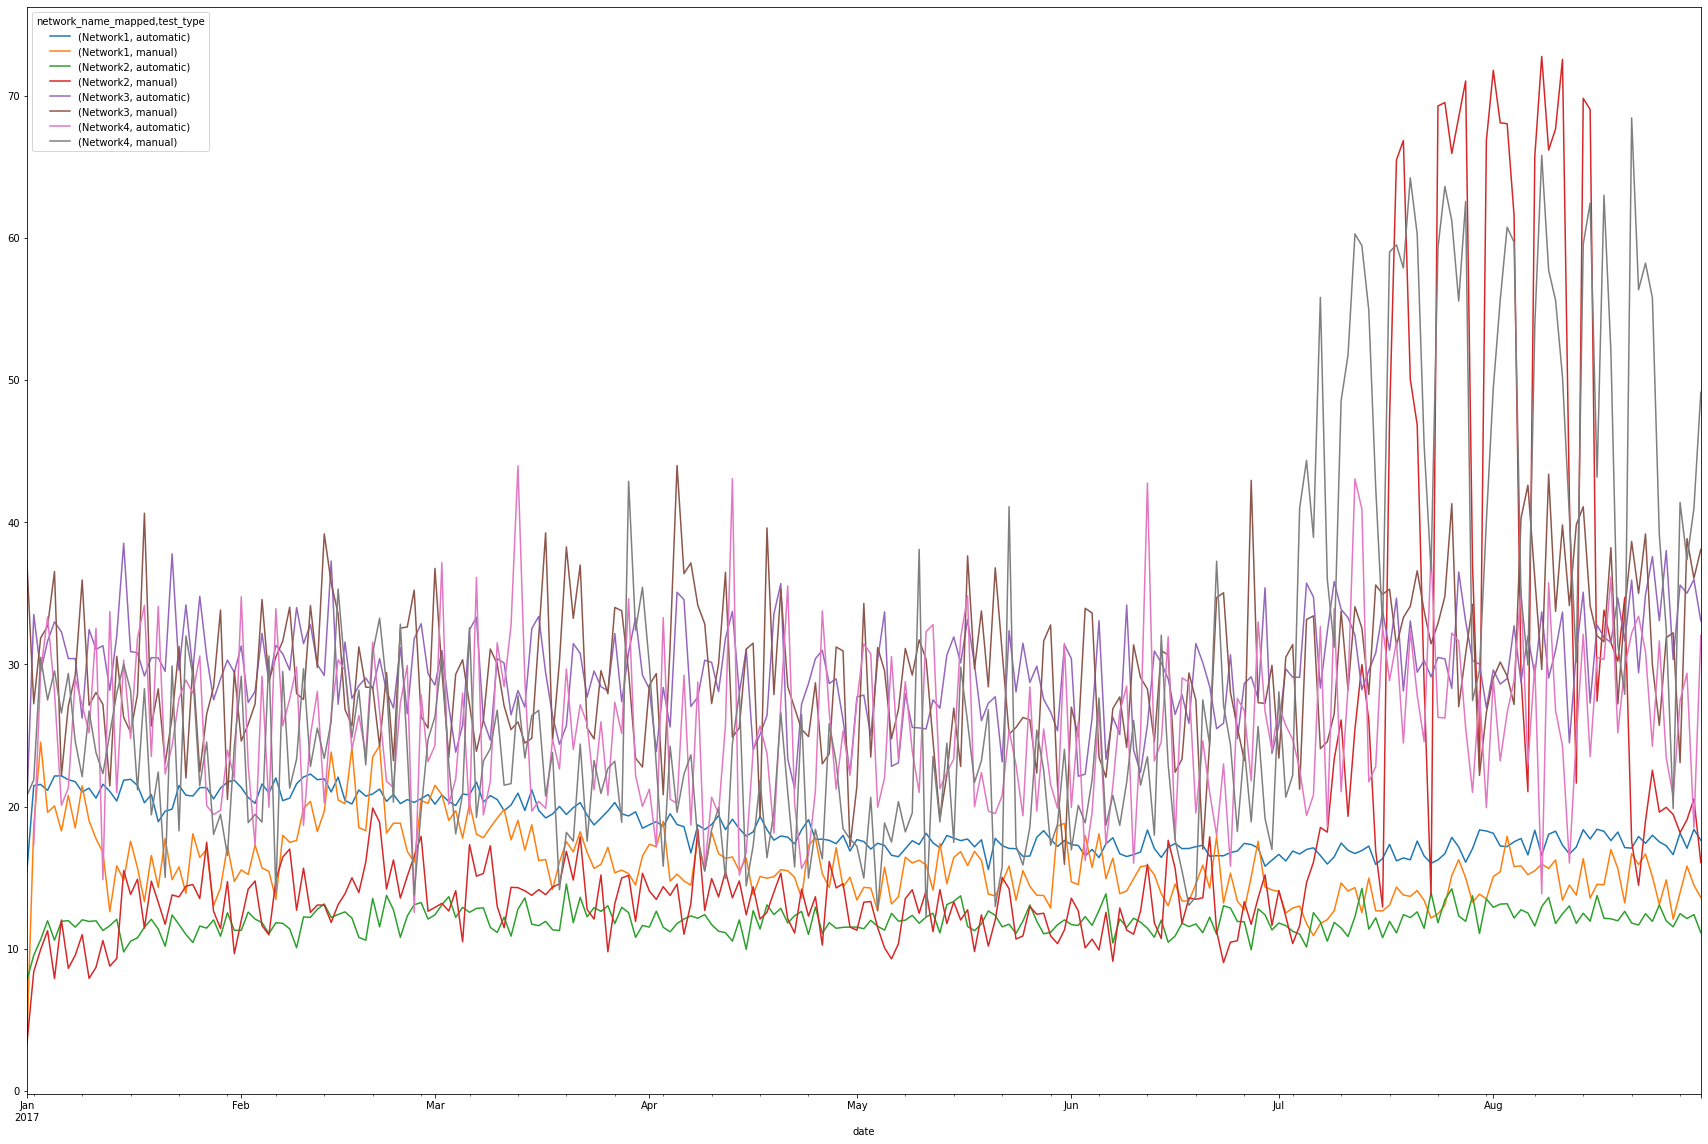

In [138]:
import matplotlib.pyplot as plt

df_daily_speed.plot(figsize=(30, 20))

In [139]:
df_daily_speed.std(axis=0)

network_name_mapped  test_type
Network1             automatic     1.815754
                     manual        2.563978
Network2             automatic     0.910473
                     manual       15.580120
Network3             automatic     3.429730
                     manual        5.333205
Network4             automatic     5.832245
                     manual       13.508445
dtype: float64

As shown by the plot above, the daily download speed of manual tests is more fluctuating than that of the automatic tests. This is testified by the standard deviation, of which automatic tests of all 4 networks are much lower than that of the manual.

This could be due to:
1. The total volume of the manual tests run each day is very random, unlike the automatic tests which has a relatively quite value. This would impact on the results:
    1) if only few users run manual tests of a particular day, the daily average could be highly biased by the limited number of samples
    2) if one/mutiple users run a lot of tests manually of a particular day, the
2. The 



In [213]:
import numpy as np

window_size = 10
df_srt = df.sort_values('hour_read_at').reset_index(drop=True)
mv_avg_dfs = []
for _, df_nw in df_srt.groupby('network_name_mapped'):
    is_auto = df_nw['test_type'] == 'automatic'
    df_auto = df_nw[is_auto]
    mv_avg_auto = df_auto['download_speed'].rolling(window_size, min_periods=1).mean()
    mv_avg_ffill = mv_avg_auto.reindex(df_nw.index).ffill()
    df_avg_man = df_nw.assign(mv_avg=mv_avg_ffill)[~is_auto]
    
    # fill the missing moving average of auto tests with that of the manual tests
    mv_avg_man = df_avg_man['download_speed'].rolling(window_size, min_periods=1).mean()
    df_avg_man['mv_avg'].fillna(mv_avg_man, inplace=True) 
    mv_avg_dfs.append(df_avg_man)

df_man = pd.concat(mv_avg_dfs)
df_man
# mv_avg_dfs[1].head(30)

,device_id_time,network_name_mapped,test_type,download_speed,country,hour_read_at,date,mv_avg
23,user91501,Network1,manual,6.501000,USA,2017-01-01 04:00:00,2017-01-01,18.9518
56,user104498,Network1,manual,3.480000,USA,2017-01-01 17:00:00,2017-01-01,17.0181
87,user98663,Network1,manual,2.268500,USA,2017-01-01 21:00:00,2017-01-01,6.5566
89,user70827,Network1,manual,0.445000,USA,2017-01-01 21:00:00,2017-01-01,6.5566
90,user98663,Network1,manual,4.075500,USA,2017-01-01 21:00:00,2017-01-01,6.5566
...,...,...,...,...,...,...,...,...
786012,user11629,Network4,manual,22.537001,TWN,2017-08-31 16:00:00,2017-08-31,18.2404
786316,user7751,Network4,manual,13.786000,TWN,2017-08-31 18:00:00,2017-08-31,18.2404
786618,user1314,Network4,manual,57.084999,TWN,2017-08-31 20:00:00,2017-08-31,18.2404
786989,user1314,Network4,manual,66.050003,TWN,2017-08-31 22:00:00,2017-08-31,19.6983


In [222]:

# alpha is a hyper-parameter (between 0 and 1) that regulates the algorithm sensitivity to anomalies
def is_out_cflevel(data, mean, alpha=1, std_rolling=False, w_size=window_size):
    residual = data - mean
    if std_rolling:
        std = residual.rolling(w_size).std() 
        std.fillna(std.iloc[w_size - 1], inplace=True)
    else:
        std = np.std(residual)
    scaled_rsd = residual * alpha
    return (scaled_rsd > mean + std) | (scaled_rsd < mean - std)
    

In [233]:
# low-pass filter using static std of the residual
filter_dfs = []
for df_nw in mv_avg_dfs:
    mean = df_nw['mv_avg']
    df_nw['is_anomalous'] = is_out_cflevel(df_nw['download_speed'], mean)
    gb = df_nw.groupby('date')
    is_anomalous = gb.apply(lambda x: is_out_cflevel(x['download_speed'], x['download_speed'].mean()) 
                                if x['is_anomalous'].all() else x['is_anomalous'])
    is_anomalous = is_anomalous.reset_index(0, drop=True)
    ann.append(is_anomalous)
    df_nw['is_anomalous'] = is_anomalous
    filter_dfs.append(df_nw)

df_man = pd.concat(filter_dfs)
df_man


,device_id_time,network_name_mapped,test_type,download_speed,country,hour_read_at,date,mv_avg,is_anomalous
23,user91501,Network1,manual,6.501000,USA,2017-01-01 04:00:00,2017-01-01,18.9518,True
56,user104498,Network1,manual,3.480000,USA,2017-01-01 17:00:00,2017-01-01,17.0181,True
87,user98663,Network1,manual,2.268500,USA,2017-01-01 21:00:00,2017-01-01,6.5566,False
89,user70827,Network1,manual,0.445000,USA,2017-01-01 21:00:00,2017-01-01,6.5566,False
90,user98663,Network1,manual,4.075500,USA,2017-01-01 21:00:00,2017-01-01,6.5566,False
...,...,...,...,...,...,...,...,...,...
786012,user11629,Network4,manual,22.537001,TWN,2017-08-31 16:00:00,2017-08-31,18.2404,False
786316,user7751,Network4,manual,13.786000,TWN,2017-08-31 18:00:00,2017-08-31,18.2404,False
786618,user1314,Network4,manual,57.084999,TWN,2017-08-31 20:00:00,2017-08-31,18.2404,False
786989,user1314,Network4,manual,66.050003,TWN,2017-08-31 22:00:00,2017-08-31,19.6983,False


In [248]:
df_man_flt = df_man[~df_man['is_anomalous']]
print(f'Filtered rows from {len(df_man)} to {len(df_man_flt)}')

Filtered rows from 197786 to 106780


In [237]:
df_auto = df[df['test_type'] == 'automatic']
df_flt = pd.concat([df_auto, df_man_flt])
df_daily_flt = df_flt.pivot_table(index='date', 
                                  columns=['network_name_mapped', 'test_type'], 
                                  values='download_speed')
df_daily_flt

network_name_mapped   Network1              Network2              Network3  \
test_type            automatic     manual  automatic     manual  automatic   
date                                                                         
2017-01-01           15.404101   2.263000   7.768000   3.237800  20.117000   
2017-01-02           21.476837  27.158099   9.534631   8.381938  33.520184   
2017-01-03           21.560866  34.123255  10.637897  10.126371  29.512906   
2017-01-04           21.145300  30.701340  11.966075  10.745356  31.639788   
2017-01-05           22.152335  27.924492  10.597833   7.907578  32.998448   
...                        ...        ...        ...        ...        ...   
2017-08-27           16.618623  16.302285  11.536510  13.930755  30.342679   
2017-08-28           18.136839  18.442748  12.467090  10.073685  35.588551   
2017-08-29           17.069146  19.287508  12.123170  14.235975  35.016442   
2017-08-30           18.394833  19.069803  12.399099  15.863776  35.975456   
2017-08-31           17.629559  18.409556  11.121202  10.592249  33.063190   

network_name_mapped              Network4             
test_type               manual  automatic     manual  
date                                                  
2017-01-01                 NaN        NaN  20.754999  
2017-01-02           45.854666  17.309524  20.558016  
2017-01-03           37.310103  29.500267  34.980316  
2017-01-04           42.957500  33.346077  47.618818  
2017-01-05           56.682651  28.115900  45.002156  
...                        ...        ...        ...  
2017-08-27           55.901429  20.710900  17.770299  
2017-08-28           53.567749  27.459880  53.885427  
2017-08-29           53.624845  29.384971  46.569185  
2017-08-30           44.466238  18.523550  33.940191  
2017-08-31           37.252888  32.060552  44.118105  

[243 rows x 8 columns]

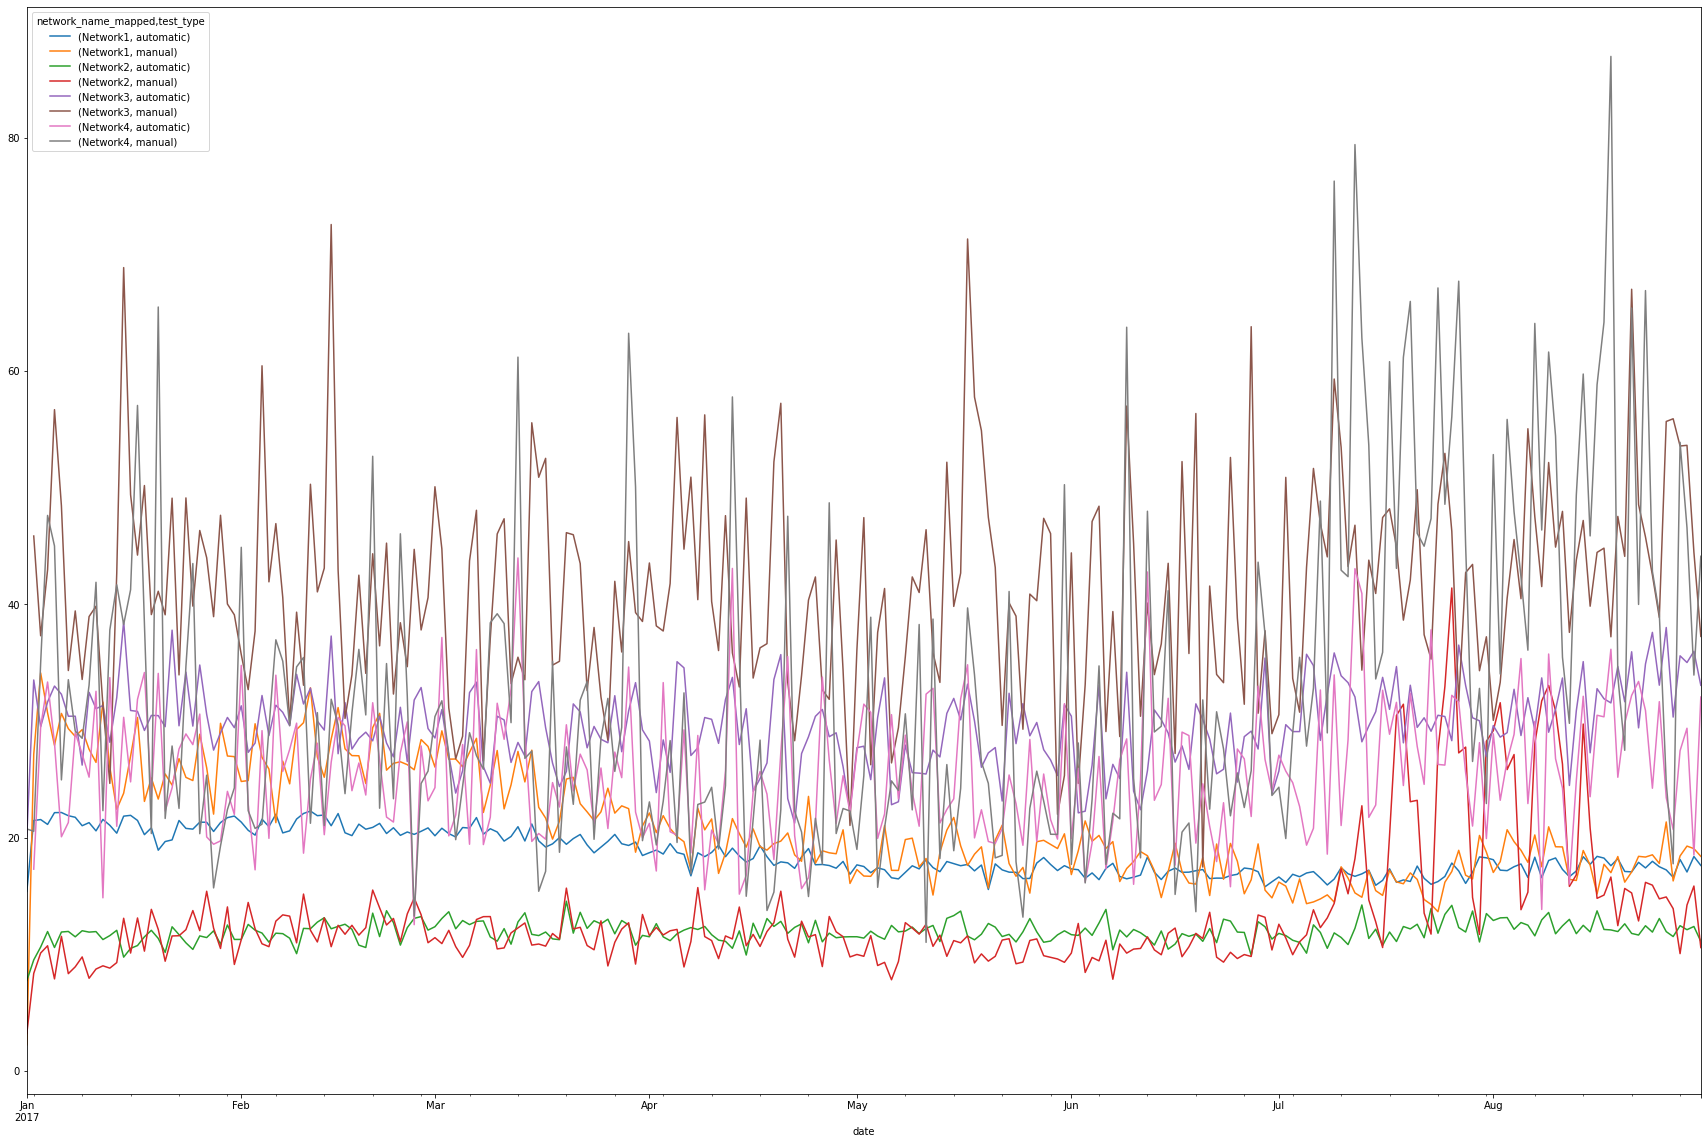

In [238]:
df_daily_flt.plot(figsize=(30, 20))

In [242]:
# low-pass filter using rolling std of the residual
filter_dfs_rolling = []
for df_nw in mv_avg_dfs:
    mean = df_nw['mv_avg']
    df_nw['is_anomalous'] = is_out_cflevel(df_nw['download_speed'], mean, std_rolling=True)
    gb = df_nw.groupby('date')
    is_anomalous = gb.apply(lambda x: is_out_cflevel(x['download_speed'], x['download_speed'].mean()) 
                                if x['is_anomalous'].all() else x['is_anomalous'])
    is_anomalous = is_anomalous.reset_index(0, drop=True)
    ann.append(is_anomalous)
    df_nw['is_anomalous'] = is_anomalous
    filter_dfs_rolling.append(df_nw)

df_man_rolling = pd.concat(filter_dfs_rolling)
df_man_rolling

,device_id_time,network_name_mapped,test_type,download_speed,country,hour_read_at,date,mv_avg,is_anomalous
23,user91501,Network1,manual,6.501000,USA,2017-01-01 04:00:00,2017-01-01,18.9518,False
56,user104498,Network1,manual,3.480000,USA,2017-01-01 17:00:00,2017-01-01,17.0181,True
87,user98663,Network1,manual,2.268500,USA,2017-01-01 21:00:00,2017-01-01,6.5566,True
89,user70827,Network1,manual,0.445000,USA,2017-01-01 21:00:00,2017-01-01,6.5566,True
90,user98663,Network1,manual,4.075500,USA,2017-01-01 21:00:00,2017-01-01,6.5566,True
...,...,...,...,...,...,...,...,...,...
786012,user11629,Network4,manual,22.537001,TWN,2017-08-31 16:00:00,2017-08-31,18.2404,False
786316,user7751,Network4,manual,13.786000,TWN,2017-08-31 18:00:00,2017-08-31,18.2404,True
786618,user1314,Network4,manual,57.084999,TWN,2017-08-31 20:00:00,2017-08-31,18.2404,False
786989,user1314,Network4,manual,66.050003,TWN,2017-08-31 22:00:00,2017-08-31,19.6983,True


In [246]:
df_man_flt_rolling = df_man_rolling[~df_man_rolling['is_anomalous']]
print(f'Filtered rows from {len(df_man_rolling)} to {len(df_man_flt_rolling)}')

Filtered rows from 197786 to 74130


In [247]:
df_flt_rolling = pd.concat([df_auto, df_man_flt_rolling])
df_daily_flt_rolling = df_flt_rolling.pivot_table(index='date', 
                                                  columns=['network_name_mapped', 'test_type'], 
                                                  values='download_speed')
df_daily_flt_rolling

network_name_mapped   Network1              Network2              Network3  \
test_type            automatic     manual  automatic     manual  automatic   
date                                                                         
2017-01-01           15.404101   6.501000   7.768000   8.411000  20.117000   
2017-01-02           21.476837  26.950151   9.534631  13.286953  33.520184   
2017-01-03           21.560866  34.302349  10.637897  16.440592  29.512906   
2017-01-04           21.145300  31.328776  11.966075  14.649045  31.639788   
2017-01-05           22.152335  29.916284  10.597833  15.008181  32.998448   
...                        ...        ...        ...        ...        ...   
2017-08-27           16.618623  19.643340  11.536510  16.129990  30.342679   
2017-08-28           18.136839  21.342179  12.467090  12.955966  35.588551   
2017-08-29           17.069146  22.259813  12.123170  17.448681  35.016442   
2017-08-30           18.394833  23.940829  12.399099  16.685894  35.975456   
2017-08-31           17.629559  21.876670  11.121202  11.864327  33.063190   

network_name_mapped              Network4             
test_type               manual  automatic     manual  
date                                                  
2017-01-01                 NaN        NaN        NaN  
2017-01-02           50.534000  17.309524  26.204151  
2017-01-03           36.098667  29.500267  47.799500  
2017-01-04           45.585771  33.346077  51.763750  
2017-01-05           57.740403  28.115900  51.178764  
...                        ...        ...        ...  
2017-08-27           58.070650  20.710900  25.190856  
2017-08-28           52.017126  27.459880  51.738580  
2017-08-29           53.593011  29.384971  47.008908  
2017-08-30           48.605880  18.523550  39.044648  
2017-08-31           41.660412  32.060552  51.115576  

[243 rows x 8 columns]

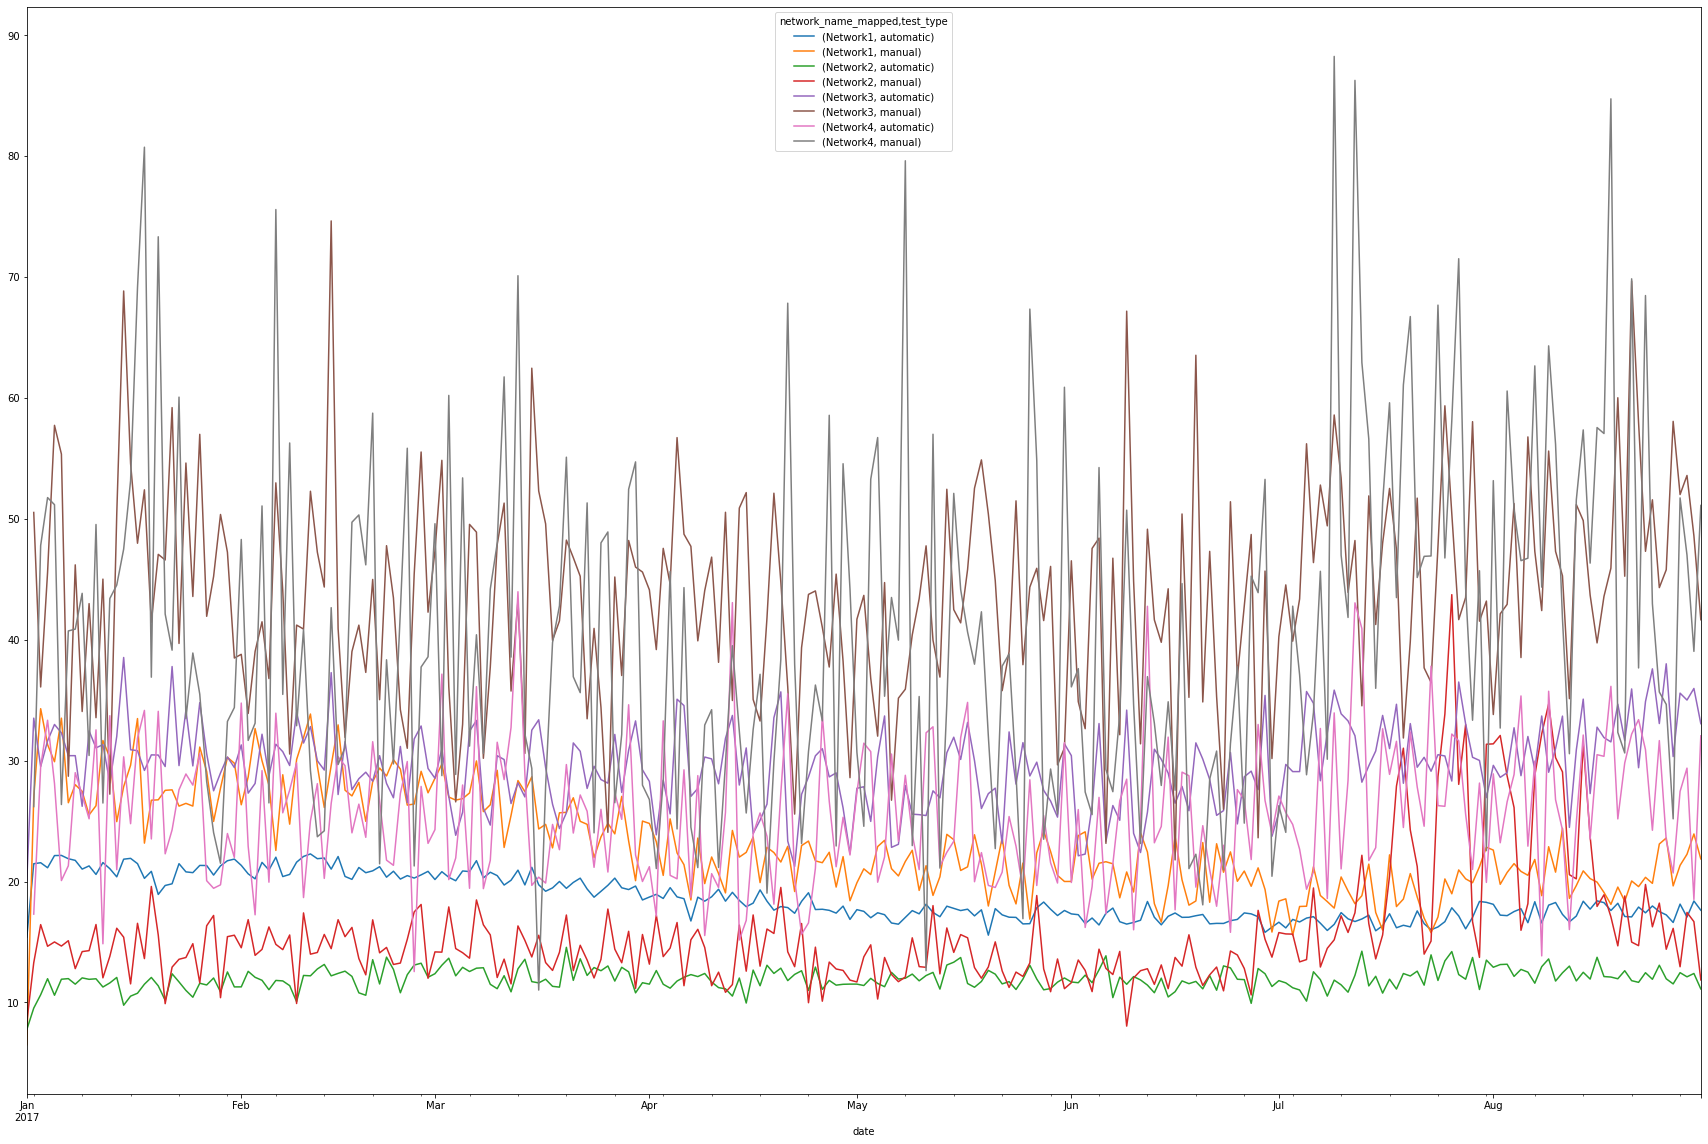

In [244]:
df_daily_flt_rolling.plot(figsize=(30, 20))